In [64]:
import pandas as pd
import numpy as np
import networkx as nx
import glob

from collections import defaultdict

import matplotlib.pyplot as plt

In [3]:
recs = pd.read_csv(r'C:/Users/Roan/Documents/bachelor_scriptie/Machine Learning/predicted.csv').drop("Unnamed: 0", axis = 1)

In [4]:
recs = recs[["user", "vids_watched", "vid", "conspiracy_pred", "strategy"]]
recs.head()

,user,vids_watched,vid,conspiracy_pred,strategy
0,scriptiebot1@gmail.com,1,Jjge2pYKuUM,False,strategy 1
1,scriptiebot1@gmail.com,1,5yx6BWlEVcY,False,strategy 1
2,scriptiebot1@gmail.com,1,Bj9PLkKNF-c,False,strategy 1
3,scriptiebot1@gmail.com,1,SMNHZR1u6KQ,False,strategy 1
4,scriptiebot1@gmail.com,1,46siYNcHMxM,False,strategy 1


In [33]:
strats = recs[["user", "strategy"]].drop_duplicates()

In [34]:
path = r'C:/Users/Roan/Documents/bachelor_scriptie/Results/experiment 1'

all_files = glob.glob(path + "/strat_*/watched*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=0, header=0)
    li.append(df)

watched = pd.concat(li, axis=0, ignore_index=True)

In [35]:
watched = pd.merge(watched, strats, left_on="user", right_on="user")

In [130]:
graphs = {"strategy 1" : nx.DiGraph(), "strategy 2" : nx.DiGraph(), 
          "strategy 3" : nx.DiGraph(), "strategy 4" : nx.DiGraph()}

for strat in graphs:
    for i in watched.query("strategy == @strat").itertuples():
        # User, vid number, url
        u, n, url = i[1:4]
        url = url.split("?v=")[1].split("&t=")[0]
        
        # Find recommendations from current video
        p = recs.query("(user == @u) & (vids_watched == @n)")

        # Set seed node
        graphs[strat].add_node(url, vid_type = "seed")
        
        # Add recommendations and their types
        graphs[strat].add_nodes_from([x[3].split("&t=")[0] for x in p.itertuples() if x[-2]], vid_type = "conspiracy")
        graphs[strat].add_nodes_from([x[3].split("&t=")[0] for x in p.itertuples() if not x[-2]], vid_type = "regular")
            
        # Add edges
        graphs[strat].add_edges_from([(url, x[3].split("&t=")[0]) for x in p.itertuples()])

In [133]:
colors = defaultdict(list)

# Determine colors of nodes
for strat in graphs:
    for n in graphs[strat]:
        vid_type = graphs[strat].nodes[n]["vid_type"]
        if vid_type == "seed":
            colors[strat].append("grey")
        elif vid_type == "regular":
            colors[strat].append("blue")
        else:
            colors[strat].append("red")            

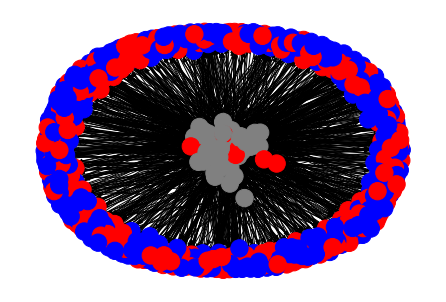

In [134]:
nx.draw(graphs["strategy 4"], node_color=colors["strategy 4"])

In [116]:
metrics = defaultdict(list)

# Find metrics for each network
for strat in graphs:
    metrics["betweenness_centrality"].append(np.mean(list(nx.betweenness_centrality(graphs[strat]).values())))
    metrics["clustering_coefficient"].append(np.mean(list(nx.clustering(graphs[strat]).values())))
    
    metrics["density"].append(nx.density(graphs[strat]))
    metrics["size"].append(graphs[strat].size())
    
    metrics["SCC"].append(len(max(list(nx.strongly_connected_components(graphs[strat])), key=len)))
    
    try:
        metrics["avg path length"].append(nx.average_shortest_path_length(graphs[strat]))
    except:
        metrics["avg path length"].append(np.nan)
    
metrics = pd.DataFrame(metrics, index=graphs.keys())

In [117]:
metrics

,betweenness_centrality,clustering_coefficient,density,size,SCC,avg path length
strategy 1,1.597418e-07,0.001592,0.002049,1420,1,NaN
strategy 2,0.000000e+00,0.000000,0.002432,1440,1,NaN
strategy 3,2.198488e-06,0.009512,0.002101,1428,4,0.004728
strategy 4,1.136934e-04,0.039018,0.002237,1387,15,0.111545
